# Digit recognition 

In [1]:
#imports: 
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,   TensorDataset
import torch.nn as nn
import torch.optim as optim
from typing import  Callable
from tqdm import tqdm
import torch.nn.functional as F

# Data preprocessing 

In [2]:
#Here we load the custom test set data as an array
X_test2 = np.load('digits_X.npy') 
y_test2 = np.load('digits_y.npy') 
 
#Converts the arrays to tensors
X_test_tensor = torch.tensor(X_test2, dtype=torch.float32)  
y_test_tensor = torch.tensor(y_test2, dtype=torch.long)   

#Unsqueeze the tensor to match the train data format
X_test_tensor = X_test_tensor.unsqueeze(1)

#Normalize the data in range to [-1, 1]
transform = transforms.Normalize((0.5,), (0.5,))  
X_test_tensor /= 255.0
X_test_tensor = transform(X_test_tensor)

#Create a dataset
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

#Create a Dataloader for the later training
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True   
)


In [3]:

#Define the transformation for the train data to normalize it in the range of [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)) 
])
#Load the train data from torchviosn package (if the data is already downloaded, set download to False)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validationset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
validationloader = DataLoader(validationset, batch_size=32, shuffle=False)

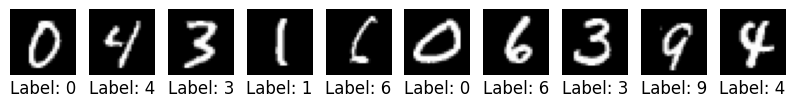

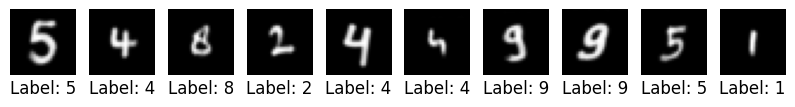

In [4]:
#Let's display the train and custom test sets data 
for images, labels in trainloader:
    break #loads on ebatch of  train data
fig, axes = plt.subplots(1, 10, figsize=(10, 1))

#displays the train set 
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].reshape(28, 28), cmap='gray') 
    ax.text(0.5, -0.2, f'Label: {labels[i].item()}', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')

    ax.axis('off')  

plt.show()

#Test set 
for images, labels in test_loader:
    break
fig, axes = plt.subplots(1, 10, figsize=(10, 1))

for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].reshape(28, 28), cmap='gray') 
    ax.text(0.5, -0.2, f'Label: {labels[i].item()}', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='black')

    ax.axis('off')  

plt.show()

As we can see the custom pictures are a bit more blurry, but the digits look still easily distinguishable.

# Defining the models

In [5]:
class SimpleNN1(nn.Module):
    "A model with one fully connected layer"
    def __init__(self, input_size=28*28, hidden_size = 128, output_size = 10):
        super(SimpleNN1, self).__init__() 
        #initializes the input layer with a input dimension of 28*28 
        self.fc1 = nn.Linear(input_size, hidden_size)
        #initializes a hidden layer with a hidden size of 128 nodes and output size of 10 (number of classes/digits)
        self.fc2 = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        #flattens the input impage to match the input dimension
        x = x.view(-1, 28*28) 
        #applies the relu activation function on the output of the first layer to introduce non-linearity
        x = torch.relu(self.fc1(x)) 
        # passes the output to the second layer and returns the output
        x = self.fc2(x) 
        return x  

In [6]:
class SimpleNN3(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=128, hidden_size2=64, hidden_size3=32, output_size=10):
        super(SimpleNN3, self).__init__()
        "A model with 3 fully connected layers"
        
        #3 hidden layers
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        
        #output layer
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        #flatten the input
        x = x.view(-1, 28*28)
        #applies the activation function to the output and passes the result to the next level
        x = torch.relu(self.fc1(x))   
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x


In [7]:
class Conv(nn.Module):
    def __init__(self, input_channels=1, output_size=10):
        super(Conv, self).__init__()
        "A model with 3 convolutional layers"

        #define the conv layers with a kernel size of 3, stride and padding of 1
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        #dropout rate to redue overfitting
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.2)
        # two fully connected layers at the end to map the extracted features to the correct class
        self.fc1 = nn.Linear(128 * 3 * 3, 512) 
        self.fc2 = nn.Linear(512,output_size)

    def forward(self, x):
        # applies the relu activation function to the output of the convolutional layer 
        x = F.relu(self.conv1(x))
        # max pool for reduce of the dimensionality
        x = F.max_pool2d(x, 2) 
        x = self.dropout1(x) 
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2) 
        x = self.dropout2(x)  

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2) 
        x = self.dropout2(x)
        
        # flettens teh output to pass the extrax=cted features to the fc layer
        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Defining the train loop

In [8]:


def train_batch(network: torch.nn.Module,
                X_batch: torch.Tensor,
                Y_batch: torch.Tensor,
                loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],  
                optimizer: torch.optim.Optimizer) -> float:
    network.train()
    
    prediction_batch = network(X_batch)  #forward pass
    batch_loss = loss_fn(prediction_batch.squeeze(), Y_batch)  #loss calculation
    batch_loss.backward()  #gradient computation
    optimizer.step()  #back-propagation
    optimizer.zero_grad()  #gradient reset
    return batch_loss.item()


def train_epoch(network: torch.nn.Module, 
                dataloader: DataLoader,
                loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                optimizer: torch.optim.Optimizer, 
                device: str) -> float:
    
    loss = 0.
    for i, (x_batch, y_batch) in enumerate(tqdm(dataloader)):
        x_batch = x_batch.to(device) #convert back to your chosen device
        y_batch = y_batch.to(device)
        loss += train_batch(network=network, X_batch=x_batch, Y_batch=y_batch, 
                            loss_fn=loss_fn, optimizer=optimizer)
    loss /= (i + 1)  #divide loss by number of batches for consistency 
        
    return loss

def eval_batch(network: torch.nn.Module,
                X_batch: torch.Tensor,
                Y_batch: torch.Tensor,
                loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor]) -> float:
    network.eval() # turns on the evaluation mode
    
    with torch.no_grad():
        prediction_batch = network(X_batch)  # forward pass
        batch_loss = loss_fn(prediction_batch.squeeze(), Y_batch)  # loss calculation
        
    return batch_loss.item()

def eval_epoch(network: torch.nn.Module, 
                dataloader: DataLoader,
                loss_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
                device: str) -> float:
    
    loss = 0.
    
    for i, (x_batch, y_batch) in enumerate(dataloader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss += eval_batch(network=network, X_batch=x_batch, Y_batch=y_batch, loss_fn=loss_fn)
    loss /= (i + 1) #calcultaes the average loss for all train data
        
    return loss


In [9]:
def measure_accuracy(network: torch.nn.Module,
                     dataloader: DataLoader,
                     device: str) -> float:
    """
        Given a network, a dataloader and a device, iterates over the 
        dataset and returns the network's accuracy.
    """
    network.eval()  # evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            pred = model(x_batch)   # feed the model with the test data to output logits
            pred = torch.argmax(pred, dim=1) # calculates the prediction class
            local_total = y_batch.shape[0] # retrieves actual classes
            local_correct = (pred == y_batch).sum().item() # calculates the number of correctly identified digits 
            correct += local_correct
            total += local_total
    return correct/total 

In [11]:
def train_model(model, n_epochs=5):
    """
        Defines the train loop
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    criterion = nn.CrossEntropyLoss() #loss function for multi-class classification tasks
    optimizer = optim.AdamW(model.parameters(), lr=0.001) #define the optimizer to adjust the learning rate and momentum
    model.to(device) 
    NUM_EPOCHS = n_epochs 
    train_losses = [] #stores the train losses for each epoch
    test_accuracies = [] # #stores the test accurcaies for each epoch

    for t in range(NUM_EPOCHS): # iterates over the epochs
        model.train()
        train_loss = train_epoch(model, trainloader, optimizer=optimizer, loss_fn=criterion, device=device)
        test_acc = measure_accuracy(model, test_loader, device=device)
        print('Epoch {}'.format(t))
        print(' Training Loss: {}'.format(train_loss))
        print(' Validation Accuracy: {}'.format(test_acc))
        train_losses.append(train_loss)
        test_accuracies.append(test_acc)
    return train_losses, test_accuracies



    

# Model training

In [13]:
# Network wth 1 FC layer 

train_loss = np.zeros((3, 5)) # stores the train losses for each model 
test_acc = np.zeros((3,5)) # stores the test accuracies for each model 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleNN1() #define the model
train, test = train_model(model) # train
train_loss[0] = train
test_acc[0] = test
print(f'Test set accuracy of a network with 1 fully connected layers:: {test_acc[0, -1]}')

100%|██████████| 1875/1875 [00:22<00:00, 83.60it/s] 


Epoch 0
 Training Loss: 0.3433194528281689
 Validation Accuracy: 0.506896551724138


100%|██████████| 1875/1875 [00:18<00:00, 100.34it/s]


Epoch 1
 Training Loss: 0.1739277897462249
 Validation Accuracy: 0.5310344827586206


100%|██████████| 1875/1875 [00:19<00:00, 95.90it/s] 


Epoch 2
 Training Loss: 0.13118997346833347
 Validation Accuracy: 0.5620689655172414


100%|██████████| 1875/1875 [00:23<00:00, 79.79it/s]


Epoch 3
 Training Loss: 0.1064226047274967
 Validation Accuracy: 0.5827586206896552


100%|██████████| 1875/1875 [00:20<00:00, 92.56it/s]

Epoch 4
 Training Loss: 0.092997692638884
 Validation Accuracy: 0.5
Test set accuracy of a network with 1 fully connected layers:: 0.5


In [14]:
# Network wth 3 FC layer 

model = SimpleNN3()
train, test = train_model(model)
train_loss[1] = train
test_acc[1] = test
print(f'Test set accuracy for a network with 3 fully connected layers: {test_acc[1, -1]}')

100%|██████████| 1875/1875 [00:21<00:00, 85.23it/s]


Epoch 0
 Training Loss: 0.3855676405052344
 Validation Accuracy: 0.496551724137931


100%|██████████| 1875/1875 [00:22<00:00, 82.36it/s]


Epoch 1
 Training Loss: 0.1753551576755941
 Validation Accuracy: 0.5620689655172414


100%|██████████| 1875/1875 [00:22<00:00, 85.14it/s]


Epoch 2
 Training Loss: 0.1355907711373021
 Validation Accuracy: 0.5551724137931034


100%|██████████| 1875/1875 [00:21<00:00, 87.80it/s]


Epoch 3
 Training Loss: 0.11248741852901877
 Validation Accuracy: 0.496551724137931


100%|██████████| 1875/1875 [00:21<00:00, 86.39it/s]


Epoch 4
 Training Loss: 0.0982852792082044
 Validation Accuracy: 0.5379310344827586
Test set accuracy for a network with 3 fully connected layers: 0.5379310344827586


In [15]:
## Network wth 3 conv layer 
model = Conv()
train, test = train_model(model)
train_loss[2] += train
test_acc[2] += test
print(f'Test set accuracy for a network with 3 convolutional connected layers: {test_acc[2, -1]}')


  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [00:32<00:00, 57.69it/s]


Epoch 0
 Training Loss: 0.1670270388635341
 Validation Accuracy: 0.8


100%|██████████| 1875/1875 [00:28<00:00, 65.90it/s]


Epoch 1
 Training Loss: 0.05814958751186108
 Validation Accuracy: 0.8103448275862069


100%|██████████| 1875/1875 [00:29<00:00, 62.56it/s]


Epoch 2
 Training Loss: 0.047065231845745195
 Validation Accuracy: 0.8551724137931035


100%|██████████| 1875/1875 [00:29<00:00, 63.91it/s]


Epoch 3
 Training Loss: 0.037809651680638975
 Validation Accuracy: 0.8793103448275862


100%|██████████| 1875/1875 [00:29<00:00, 63.55it/s]

Epoch 4
 Training Loss: 0.032757277622892676
 Validation Accuracy: 0.8724137931034482
Test set accuracy for a network with 3 convolutional connected layers: 0.8724137931034482


# The visualization of the model results

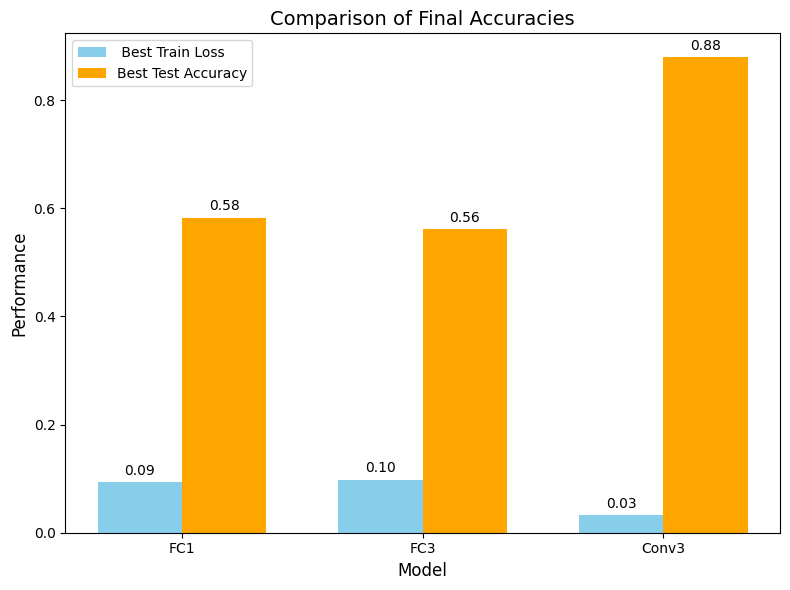

In [19]:

models = ['FC1', 'FC3', 'Conv3']
best_loss = np.min(train_loss, axis=1) # Best train loss
best_acc  = np.max(test_acc, axis=1) # Best test accuracy

#position of bars on the x-axis
x = np.arange(len(models))

#bar width
bar_width = 0.35

#plotting the grouped bars
fig, ax = plt.subplots(figsize=(8, 6))
bar1 = ax.bar(x - bar_width / 2, best_loss, bar_width, label=' Best Train Loss', color='skyblue')
bar2 = ax.bar(x + bar_width / 2, best_acc, bar_width, label='Best Test Accuracy', color='orange')

#annotating the bars
ax.bar_label(bar1, fmt='%.2f', padding=3, fontsize=10, color='black')
ax.bar_label(bar2, fmt='%.2f', padding=3, fontsize=10, color='black')


#adding labels, title, and legend
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Performance', fontsize=12)
ax.set_title('Comparison of Final Accuracies', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()



#show plot
plt.tight_layout()
plt.show()


# A model with biologically plausible error propagation (using Hebbian rule for the update).

In [27]:
class HebbianConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, learning_rate=0.01):
        super(HebbianConvLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.learning_rate = learning_rate

        # initialize the filters randomly
        self.filters = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))

    def forward(self, x):
        # apply a convolution to the input
        out = F.conv2d(x, self.filters, stride=self.stride, padding=self.padding)
        return out

    def hebbian_update(self, x, output):
        """ perform the Hebbian update on the filters based on the input and output activations"""
        with torch.no_grad():
            # process one item in the batch at a time
            for i in range(x.size(0)):
                # flatten the input activations for simplicity
                input_activations = x[i].view(self.in_channels, -1)  # shape becomes (c, h*w)
                # flatten the output activations as well
                output_activations = output[i].view(self.out_channels, -1)
                # loop through each output channel
                for j in range(self.out_channels):
                    # calculate the Hebbian term as the outer product
                    hebbian_term = self.learning_rate * torch.ger(input_activations, output_activations[j])
                    # update the filter for the current channel
                    self.filters.data[j] += hebbian_term

# network with multiple Hebbian convolutional layers
class HebbianConvNet(nn.Module):
    def __init__(self):
        super(HebbianConvNet, self).__init__()
        # first layer: 1 input channel, 16 output channels
        self.conv1 = HebbianConvLayer(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # second layer: takes 16 inputs, outputs 32 channels
        self.conv2 = HebbianConvLayer(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # third layer: takes 32 inputs, outputs 64 channels
        self.conv3 = HebbianConvLayer(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # fully connected layers for classification
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # pass through the first convolutional layer and apply relu
        x = F.relu(self.conv1(x))
        # max pooling to reduce dimensions
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        # flatten the tensor to feed into fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def hebbian_update(self, x):
        """
        perform Hebbian updates for all convolutional layers
        """
        #run a forward pass to get the outputs of each layer
        out1 = self.conv1(x)
        out2 = self.conv2(out1)
        out3 = self.conv3(out2)
        
        #update filters in each convolutional layer using Hebbian learning
        self.conv1.hebbian_update(x, out1)
        self.conv2.hebbian_update(out1, out2)
        self.conv3.hebbian_update(out2, out3)


In [29]:
model = HebbianConvNet()
train_loss_hebbs, test_acc_hebbs = train_model(model)
print(f'Test set accuracy for a network with 3 convolutional layers: {max(test_acc_hebbs)}')

100%|██████████| 1875/1875 [00:31<00:00, 58.62it/s]


Epoch 0
 Training Loss: 1.7834077567274371
 Validation Accuracy: 0.6103448275862069


100%|██████████| 1875/1875 [00:27<00:00, 67.36it/s]


Epoch 1
 Training Loss: 0.18281385169575612
 Validation Accuracy: 0.6758620689655173


100%|██████████| 1875/1875 [00:27<00:00, 67.96it/s]


Epoch 2
 Training Loss: 0.12945305272800228
 Validation Accuracy: 0.6931034482758621


100%|██████████| 1875/1875 [00:27<00:00, 67.18it/s]


Epoch 3
 Training Loss: 0.10490125364229703
 Validation Accuracy: 0.6931034482758621


100%|██████████| 1875/1875 [00:27<00:00, 67.65it/s]

Epoch 4
 Training Loss: 0.08141600050041065
 Validation Accuracy: 0.7551724137931034
Test set accuracy for a network with 3 convolutional layers: 0.7551724137931034
